# Time Series Dense DNN Algorithm

This algorithm is used to forecast FOREX prices for the EURUSD pair. It fetches data from MetaTrader5 and applies feature engineering to create additional data.

The forecasted values are set to:
- **Position 1** if the prediction indicates that the price will go up in the next hour
- **Position 0** if the prediction indicates that the price will go down in the nex hourx hour

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
import warnings
warnings.filterwarnings("ignore")
import ta
import MetaTrader5 as mt5
from datetime import datetime
from UsefulFunctions import data, backtest

In [11]:
# Initiate bound between MetaTrader5 and Python
mt5.initialize()

True

In [13]:
# Fetching data from MetaTrader5 from 2015 to the present using the custom function "get_rates" from the data.py file
# The historical data retrieved is of 1-hour timeframe
df = data.get_rates("EURUSD", mt5.TIMEFRAME_H1, datetime(2015,1,1))
df.head()

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2015-01-02 08:00:00,1.2051,1.2057,1.2048,1.2054,134,20,0
2015-01-02 09:00:00,1.2053,1.2058,1.2034,1.2055,650,20,0
2015-01-02 10:00:00,1.2056,1.2069,1.2044,1.2047,871,20,0
2015-01-02 11:00:00,1.2048,1.2060,1.2038,1.2057,875,20,0
2015-01-02 12:00:00,1.2056,1.2056,1.2042,1.2050,441,20,0


In [15]:
# Drop columns spread and real_volume and remane columns tick_volumne to volumne
df = df[["open", "high", "low", "close", "tick_volume"]]
df.rename(columns={'tick_volume': 'volume'}, inplace=True)
df.head()

,open,high,low,close,volume
time,,,,,
2015-01-02 08:00:00,1.2051,1.2057,1.2048,1.2054,134
2015-01-02 09:00:00,1.2053,1.2058,1.2034,1.2055,650
2015-01-02 10:00:00,1.2056,1.2069,1.2044,1.2047,871
2015-01-02 11:00:00,1.2048,1.2060,1.2038,1.2057,875
2015-01-02 12:00:00,1.2056,1.2056,1.2042,1.2050,441


## Feature engineering 
**Creating new input variables from raw data**

In [18]:
# Create a second DataFrame from the close column and compute the percent change in a new column
df_copy = df[["close"]]
df_copy["pct_change"] = df_copy["close"].pct_change(1)
df_copy

,close,pct_change
time,,
2015-01-02 08:00:00,1.20540,NaN
2015-01-02 09:00:00,1.20550,0.000083
2015-01-02 10:00:00,1.20470,-0.000664
2015-01-02 11:00:00,1.20570,0.000830
2015-01-02 12:00:00,1.20500,-0.000581
...,...,...
2024-08-28 18:00:00,1.11255,-0.000368
2024-08-28 19:00:00,1.11141,-0.001025
2024-08-28 20:00:00,1.11064,-0.000693


In [75]:
# Creating new features to train the model
df_copy2 = df_copy
df_copy2["SMA 15"] = df_copy2[["close"]].rolling(15).mean().shift(1)
df_copy2["SMA 60"] = df_copy2[["close"]].rolling(60).mean().shift(1)
df_copy2["MSD 10"] = df_copy2[["close"]].rolling(10).std().shift(1)
df_copy2["MSD 30"] = df_copy2[["close"]].rolling(30).std().shift(1)

RSI = ta.momentum.RSIIndicator(df_copy2["close"], window=30, fillna=False)
df_copy2["RSI 30"] = RSI.rsi().shift(1)
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 10,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30
time,,,,,,,,
2015-01-13 20:00:00,1.1766,-0.001527,1.17871,1.180380,1.182290,0.001800,0.002610,43.903724
2015-01-13 21:00:00,1.1763,-0.000255,1.17817,1.179853,1.182247,0.001486,0.002730,40.896709
2015-01-13 22:00:00,1.1771,0.000680,1.17773,1.179367,1.182198,0.001293,0.002895,40.419403
2015-01-13 23:00:00,1.1771,0.000000,1.17743,1.178993,1.182143,0.000996,0.002961,42.277818
2015-01-14 00:00:00,1.1775,0.000340,1.17722,1.178607,1.182070,0.000779,0.003054,42.277818


In [77]:
# Using the custome function "add_shifted_columns" 5 new columns are added with shifted values from close column
# Check the docstring of the "add_shifted_columns" function from the data.py file
df_copy2 = data.add_shifted_columns(df_copy2, 5, "close")
df_copy2.dropna(inplace=True)
df_copy2.head()

,close,pct_change,SMA 10,SMA 15,SMA 60,MSD 10,MSD 30,RSI 30,1_close_bars_ago,2_close_bars_ago,3_close_bars_ago,4_close_bars_ago,5_close_bars_ago
time,,,,,,,,,,,,,
2015-01-14 01:00:00,1.1776,0.000085,1.17717,1.178113,1.182008,0.000738,0.003099,43.225382,1.1775,1.1771,1.1771,1.1763,1.1766
2015-01-14 02:00:00,1.1770,-0.000510,1.17724,1.177820,1.181953,0.000743,0.003139,43.465400,1.1776,1.1775,1.1771,1.1771,1.1763
2015-01-14 03:00:00,1.1772,0.000170,1.17733,1.177573,1.181877,0.000636,0.003143,42.354030,1.1770,1.1776,1.1775,1.1771,1.1771
2015-01-14 04:00:00,1.1778,0.000510,1.17725,1.177380,1.181852,0.000591,0.003130,42.857848,1.1772,1.1770,1.1776,1.1775,1.1771
2015-01-14 05:00:00,1.1773,-0.000425,1.17726,1.177287,1.181843,0.000600,0.003096,44.366825,1.1778,1.1772,1.1770,1.1776,1.1775


## Implementing Machine Learning

In [162]:
# Splitting the data into features and labels for the ML model using the custom function "split_data" from data.py file
X = df_copy2.iloc[:,2:]
y = df_copy2["pct_change"]

X_train, y_train, X_test, y_test = data.split_data(X, y, 70)

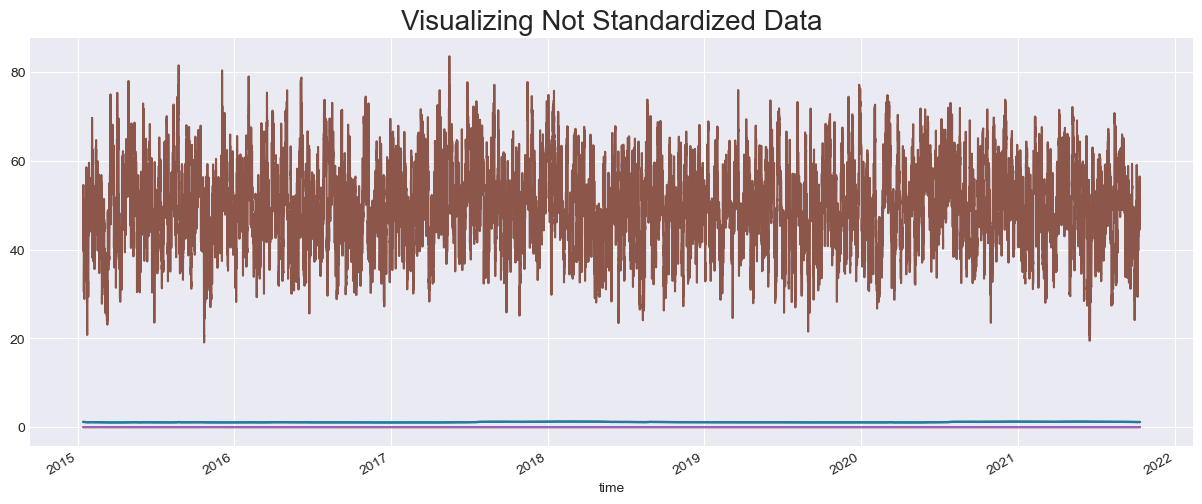

In [164]:
# Plotting features before standardization to visualize their unequal scales
X_train.plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Not Standardized Data", fontsize=20)
plt.show()

### Applying StandardScaler to Normalize Features

In [183]:
from sklearn.preprocessing import StandardScaler 

In [185]:
# Only the feature sets (X) need to be standardized, not the targets (y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

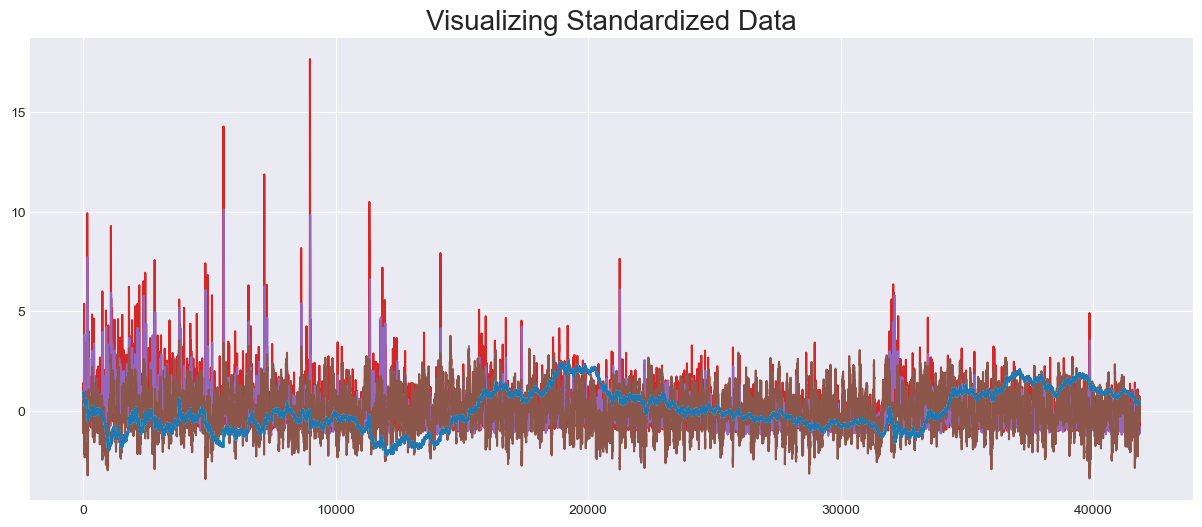

In [187]:
pd.DataFrame(X_train_scaled).plot(figsize=(15, 6))
plt.legend().set_visible(False)
plt.title("Visualizing Standardized Data", fontsize=20);

## Training the Deep Neural Network Model

In [213]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [267]:
# Number of hidden layers to add to the model
hidden_layers = 2

# Initialize a Sequential model with the name "model_1"
model_1 = Sequential(name="model_1")

# Add the input layer with 50 units and specify the input shape to match the number of features in X_test_scaled
model_1.add(Dense(50, input_shape=(X_test_scaled.shape[1],), name="input_later"))

# Loop to add hidden layers to the model
for _ in range(0, hidden_layers):
    model_1.add(Dense(50, activation="relu", name=f"hidden_layer_{_}")) 

# Add the output layer with 1 unit and a linear activation function
model_1.add(Dense(1, activation="linear", name="output_layer"))

# Compile the model with Mean Absolute Error (MAE) as the loss function and Adam optimizer
model_1.compile(loss="mae", optimizer=Adam(), metrics=["mae"])

# Training the model for 25 epochs and saving its training history for plotting learning curves
history = model_1.fit(X_train_scaled, y_train, epochs=25)

Epoch 1/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0200 - mae: 0.0200
Epoch 2/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0031 - mae: 0.0031
Epoch 3/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0012 - mae: 0.0012
Epoch 4/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 8.0940e-04 - mae: 8.0940e-04
Epoch 5/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.9022e-04 - mae: 7.9022e-04
Epoch 6/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.3404e-04 - mae: 7.3404e-04
Epoch 7/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.2995e-04 - mae: 7.2995e-04
Epoch 8/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 7.4004e-04 - mae: 7.4004e-04
Epoch 9/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.9392e-04 - mae: 8.9392e-04
Epoch 10/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - loss: 7.3106e-04 - mae: 7.3106e-04
Epoch 11/25
1308/1308 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.9873e-04 - mae: 6.9873e-04
Epoch 12/25
1308/13

In [277]:
# Displaying the model architecture and details
model_1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_later (Dense)             │ (None, 50)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_0 (Dense)          │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_layer_1 (Dense)          │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,255 (67.41 KB)

 Trainable params: 5,751 (22.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,504 (44.94 KB)

In [279]:
# Testing the model on the test set to evaluate performance
model_1.evaluate(X_test_scaled, y_test)

561/561 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 7.5715e-04 - mae: 7.5715e-04


[0.0007156728534027934, 0.0007156728534027934]

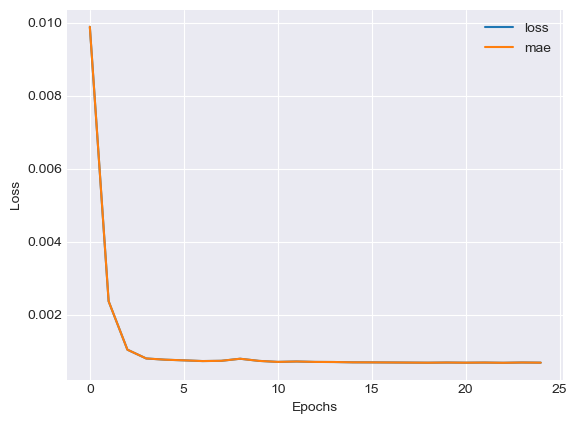

In [281]:
# Plotting learning curves for training loss over epochs
pd.DataFrame(history.history).plot()
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()